In [1]:
import simulation
import numpy as np
from scipy.stats import rayleigh

L = 50.0
M = 3

r_values = np.arange(0, 5.01, 0.01)

# 2D standard normal distribution radial density
# The radial distribution for a 2D normal is proportional to Rayleigh distribution with scale 1 (standard normal case)
def density(r):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * r**2)

radial_density_values = density(r_values)
q_values = np.arange(0, 1.0, 0.001)
inverse_radial_values = rayleigh.ppf(q_values, scale=1.0)
g2 = simulation.PyGrid2(
    M=M,
    areaLen=[L, L],
    cellCount=[L, L],
    isPeriodic=True,
    birthRates=[1]*M,
    deathRates=[0]*M,
    ddMatrix=[0.1, 0.2, 0.1,
              0.1, 0.1, 0.2,
              0.2, 0.1, 0.1, ],         # 1x1 for single species
    birthX=[q_values.tolist()]*M,     # example
    birthY=[inverse_radial_values.tolist()]*M,
    deathX_=[ [ r_values.tolist()]*M]*M,
    deathY_=[ [ radial_density_values.tolist() ]*M ]*M,
    cutoffs=[5.0]*M*M,
    seed=42,
    rtimeLimit=7200.0
)


# Parameters
N = 1000  # Number of [x, y] pairs per group

# Generate the list
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(N)]
    coordinates.append(group)

g2.placePopulation(coordinates)

print("Birth rate:", g2.total_birth_rate)
print("Death rate:", g2.total_death_rate)

Birth rate: 3000.0
Death rate: 482.1259947301732


In [2]:
import pandas as pd
from tqdm import tqdm
df = pd.DataFrame()

for t in (pbar := tqdm(range(300))):
    arrays = [np.column_stack((sublist, np.full((len(sublist), 1), i))) for i, sublist in enumerate(g2.get_all_particle_coords())]
    final_array = np.vstack(arrays)
    df_t = pd.DataFrame(final_array, columns=['x', 'y', 's'])
    df_t['t'] = t
    df = pd.concat([df,df_t], ignore_index=True, sort=False)
    g2.run_for(1)
    pbar.set_description(f"Population: {final_array.shape[0]}, Progress")

Population: 22557, Progress: 100%|██████████| 300/300 [12:38<00:00,  2.53s/it]


In [3]:
from matplotlib import animation
movie_writer = animation.FFMpegWriter(fps=2, codec='h264', extra_args=['-vcodec', 'libx264'])

Animation saved as points_animation_cyclic.mp4


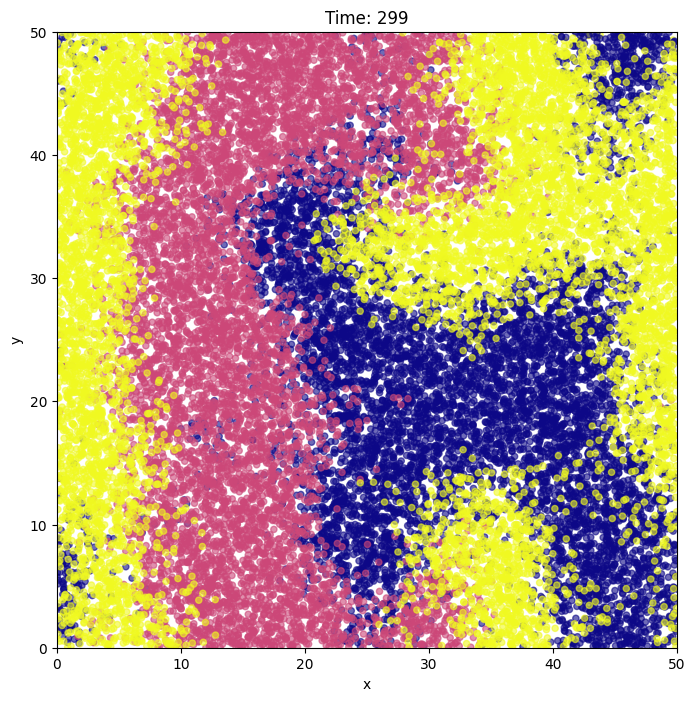

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.rcParams['animation.ffmpeg_path'] = 'C:/Users/radia/ffmpeg/bin/ffmpeg'

df = df.sort_values('t')

# Parameters
output_file = "points_animation_cyclic.mp4"

# MP4 Video Generation
fig, ax = plt.subplots(figsize=(8, 8))

# Set axis limits
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c=[], cmap='plasma', s=20, alpha=0.6)

# Animation function
def update(frame):
    current_df = df[df['t'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_array(current_df['s'].values)
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['t'].nunique(), blit=True)

# Save as MP4
ani.save(output_file, writer=movie_writer)
print(f"Animation saved as {output_file}")